## CHAPTER 10
---
# CREATING FEATURES WITH TRANSACTIONAL AND TIME SERIES DATA

---
- Time series and transactional data contain time-stamped observations, which means they share a *time dimension*.
- We often create features that aggregate or summarize the information from the historical data points of time series or transactions. For example, 
    - we can create features that capture the maximum amount that was spent by the customer in the last week, 
    - the number of transactions they made, or 
    - the time between transactions. 
- The number of features we can create and the ways in which we can aggregate this information is enormous. 
- In this chapter, we will discuss the most common ways of creating aggregated views of historical data by using pandas. 
- Then, we will make a shallow dive into Featuretools, a library designed to automate feature creation from transactional data. 
- Finally, we will point you to other Python libraries that have been devised specifically for analyzing signal complexity.

## 10.1 Aggregating transactions with mathematical operations

- Previously, we mentioned that we can aggregate information from historical data points into single observations like the maximum amount spent on a transaction, the total number of transactions, or the mean value of all transactions, to name a few examples. 
- These aggregations are made with basic mathematical operations, such as the maximum, mean, and count. 
- As you can see, mathematical operations are a simple yet powerful way to obtain a summarized view of historical data.
- In this recipe, we will create a flattened dataset by aggregating multiple transactions using common mathematical operations. 
- We will use pandas to do this.
- In a flattened dataset, we remove the time-dimension from the transaction data or time series to obtain a single observation per entity.

In [1]:
import pandas as pd
import featuretools as ft

In [2]:
# load data from feature tools
data_dict = ft.demo.load_mock_customer()

# each table in the dictionary is a pandas dataframe
type(data_dict["transactions"])

pandas.core.frame.DataFrame

In [3]:
# capture all 3 data tables into a pandas dataframe
data = data_dict["transactions"].merge(
    data_dict["sessions"]).merge(data_dict["customers"])

data.shape

(500, 11)

In [4]:
# select the columns we will work with
cols = ['customer_id', 'transaction_id', 'transaction_time', 'amount']
data = data[cols]

# display data
data.head()

,customer_id,transaction_id,transaction_time,amount
0,2,298,2014-01-01 00:00:00,127.64
1,2,2,2014-01-01 00:01:05,109.48
2,2,308,2014-01-01 00:02:10,95.06
3,2,116,2014-01-01 00:03:15,78.92
4,2,371,2014-01-01 00:04:20,31.54


In [5]:
print('Number of customers: {}'.format(data['customer_id'].nunique()))
print('Number of transactions: {}'.format(data['transaction_id'].nunique()))

Number of customers: 5
Number of transactions: 500


In [6]:
# dispay number of transactions per customer
data.groupby('customer_id')['transaction_id'].count()

customer_id
1    126
2     93
3     93
4    109
5     79
Name: transaction_id, dtype: int64

#### Aggregation with Pandas

In [7]:
# list the operations we want to perform
operations = ['sum', 'max', 'min', 'mean', 'median', 'std', 'count']

# make a list of the new feature names
feature_names = ['total_amount', 'max_amount', 'min_amount', 'mean_amount', 
                 'median_amount', 'std_amount', 'number of transactions'
                ]
df = pd.DataFrame()

# capture new features in a pandas dataframe
df[feature_names] = data.groupby('customer_id')['amount'].agg(operations)
df

,total_amount,max_amount,min_amount,mean_amount,median_amount,std_amount,number of transactions
customer_id,,,,,,,
1,9025.62,139.43,5.81,71.631905,69.715,40.442059,126
2,7200.28,146.81,8.73,77.422366,75.960,37.705178,93
3,6236.62,149.15,5.89,67.060430,58.930,43.683296,93
4,8727.68,149.95,5.73,80.070459,81.410,45.068765,109
5,6349.66,149.02,7.55,80.375443,78.870,44.095630,79


#### Aggregation with Featuretools

- To work with Featuretools, we need to transform the dataframe into an *entity set*
- Basically we pass the entire dataframe indicating the transaction_id as unique identifier and the transaction time as the time index there is one unique timestamp per transaction
- Then we indicate that within the entity set there is another table, with customer data, each customer identified with a unique customer id
- We set up the feature creation object to aggregate transactions at customer level

In [8]:
# create and entity set
es = ft.EntitySet(id="customer_data")

# add transactions table to the entity set
es.entity_from_dataframe(entity_id='transactions',
                         dataframe=data[cols],
                         index="transaction_id",
                         time_index='transaction_time')
es

Entityset: customer_data
  Entities:
    transactions [Rows: 500, Columns: 4]
  Relationships:
    No relationships

In [9]:
# within the entity set there is another table
es.normalize_entity(base_entity_id="transactions",
                    new_entity_id="customers",
                    index="customer_id")

Entityset: customer_data
  Entities:
    transactions [Rows: 500, Columns: 4]
    customers [Rows: 5, Columns: 2]
  Relationships:
    transactions.customer_id -> customers.customer_id

In [10]:
# print out the operations 
operations

['sum', 'max', 'min', 'mean', 'median', 'std', 'count']

In [11]:
# aggregate transactions at customer level
feature_matrix, features = ft.dfs(entityset=es,
                                  target_entity="customers",
                                  agg_primitives=operations,
                                  trans_primitives=[],
                                  verbose=True,
                                  )
# dataframe with the new features
feature_matrix

Built 7 features
Elapsed: 00:00 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


,SUM(transactions.amount),MAX(transactions.amount),MIN(transactions.amount),MEAN(transactions.amount),MEDIAN(transactions.amount),STD(transactions.amount),COUNT(transactions)
customer_id,,,,,,,
2,7200.28,146.81,8.73,77.422366,75.960,37.705178,93
5,6349.66,149.02,7.55,80.375443,78.870,44.095630,79
4,8727.68,149.95,5.73,80.070459,81.410,45.068765,109
1,9025.62,139.43,5.81,71.631905,69.715,40.442059,126
3,6236.62,149.15,5.89,67.060430,58.930,43.683296,93


If you compare this table to the one created in 8, the values should be identical.

## 10.2 Aggregating transactions in a time window

- When we want to predict an event at a certain point in time, often, transactions or values closer to the event tend to be more relevant. 
- Then, if we want to predict whether a customer will churn next week, the information in the last weeks or months tends to be more informative than the transactions of the customer in the past 5 years.
- We can use mathematical operations to summarize historical data, just like we did in the previous section, but only for a certain temporal window. 
- This way, we can create features such as the maximum amount spent in the last week or the number of transactions in the last month, to name a few examples. 
- In this section, we will summarize time series data over discrete time windows using pandas.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
# load the appliances energy prediction data set
cols = ['date', 'Appliances', 'lights']
data = pd.read_csv('data/energydata.csv', usecols=cols)
data.head()

,date,Appliances,lights
0,2016-01-11 17:00:00,60,30
1,2016-01-11 17:10:00,60,30
2,2016-01-11 17:20:00,50,30
3,2016-01-11 17:30:00,50,40
4,2016-01-11 17:40:00,60,40


In [14]:
data.shape

(19735, 3)

In [15]:
data.dtypes

date          object
Appliances     int64
lights         int64
dtype: object

Text(0, 0.5, 'Number of rows')

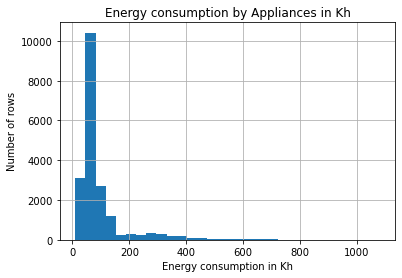

In [16]:
# histogram of electirivy consumption by appliance
data['Appliances'].hist(bins=30)
plt.title('Energy consumption by Appliances in Kh')
plt.xlabel('Energy consumption in Kh')
plt.ylabel('Number of rows')

Text(0, 0.5, 'Number of rows')

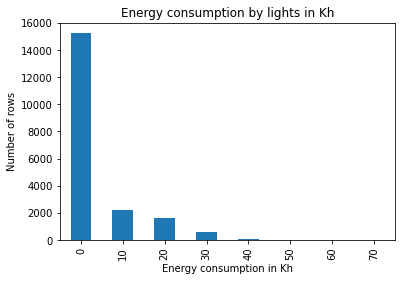

In [17]:
# Make histogram of electirivy consumption by lights 
data['lights'].value_counts().plot.bar()
plt.title('Energy consumption by lights in Kh')
plt.xlabel('Energy consumption in Kh')
plt.ylabel('Number of rows')

In [18]:
# check maximun and minimum dates
data['date'].agg(['min', 'max'])

min    2016-01-11 17:00:00
max    2016-05-27 18:00:00
Name: date, dtype: object

Text(0.5, 1.0, 'Energy consumption by Appliances in time')

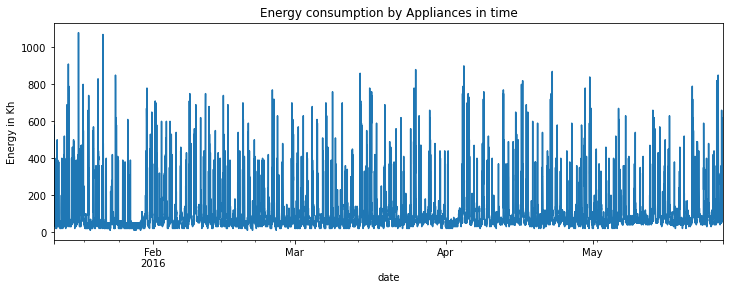

In [19]:
# parse the date column as datetime data type
data['date'] = pd.to_datetime(data['date'])

# plot consumption per timepoint by appliances
tmp = data.copy()
tmp.index = tmp['date']

tmp['Appliances'].plot(figsize=(12, 4))
plt.ylabel('Energy in Kh')
plt.title('Energy consumption by Appliances in time')

Text(0.5, 1.0, 'Energy consumption by lights in time')

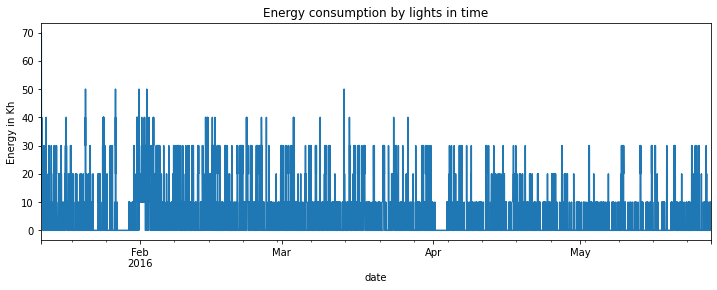

In [20]:
# plot consumption per timepoint by lights
tmp['lights'].plot(figsize=(12,4))
plt.ylabel('Energy in Kh')
plt.title('Energy consumption by lights in time')

### Determine statistical parameters per hr
#### Single operation
Two ways to do it:
1. Aggregate the data in 60 min views: the value displayed by the features represents the average of the current and 5 precedent rows of data
2. Indicate rolling time: instead of averaging the previous 6 rows, now we indicate a time period Pandas rolling will use the date variable to determine the periods

In [21]:
# method 1
data_rolled = data.rolling(window=6, on='date').mean()
data_rolled.head(10)

,date,Appliances,lights
0,2016-01-11 17:00:00,NaN,NaN
1,2016-01-11 17:10:00,NaN,NaN
2,2016-01-11 17:20:00,NaN,NaN
3,2016-01-11 17:30:00,NaN,NaN
4,2016-01-11 17:40:00,NaN,NaN
5,2016-01-11 17:50:00,55.000000,35.000000
6,2016-01-11 18:00:00,55.000000,38.333333
7,2016-01-11 18:10:00,55.000000,41.666667
8,2016-01-11 18:20:00,56.666667,43.333333
9,2016-01-11 18:30:00,60.000000,43.333333


In [22]:
# method 2
data_rolled = data.rolling(window='60min', on='date', min_periods=6).mean()
data_rolled.head(10)

,date,Appliances,lights
0,2016-01-11 17:00:00,NaN,NaN
1,2016-01-11 17:10:00,NaN,NaN
2,2016-01-11 17:20:00,NaN,NaN
3,2016-01-11 17:30:00,NaN,NaN
4,2016-01-11 17:40:00,NaN,NaN
5,2016-01-11 17:50:00,55.000000,35.000000
6,2016-01-11 18:00:00,55.000000,38.333333
7,2016-01-11 18:10:00,55.000000,41.666667
8,2016-01-11 18:20:00,56.666667,43.333333
9,2016-01-11 18:30:00,60.000000,43.333333


#### Multiple built-in operations
Create multiple summaries for every 60 min window
- Start by making a list of the operations we want to perform
- Create a dictionary with the operations to apply to each variable
- And finally, create the aggregations

In [23]:
# make a list 
operations = ['sum', 'max', 'min', 'mean', 'median', 'std']

# we will apply all operations to both variables
op_dict = {key: operations for key in ['Appliances', 'lights']}
op_dict

{'Appliances': ['sum', 'max', 'min', 'mean', 'median', 'std'],
 'lights': ['sum', 'max', 'min', 'mean', 'median', 'std']}

In [24]:
# aggregations
data_rolled = data.set_index('date').rolling(window='60min').agg(op_dict)
data_rolled.head(10)

Appliances                                         lights  \
                           sum   max   min       mean median       std    sum   
date                                                                            
2016-01-11 17:00:00       60.0  60.0  60.0  60.000000   60.0       NaN   30.0   
2016-01-11 17:10:00      120.0  60.0  60.0  60.000000   60.0  0.000000   60.0   
2016-01-11 17:20:00      170.0  60.0  50.0  56.666667   60.0  5.773503   90.0   
2016-01-11 17:30:00      220.0  60.0  50.0  55.000000   55.0  5.773503  130.0   
2016-01-11 17:40:00      280.0  60.0  50.0  56.000000   60.0  5.477226  170.0   
2016-01-11 17:50:00      330.0  60.0  50.0  55.000000   55.0  5.477226  210.0   
2016-01-11 18:00:00      330.0  60.0  50.0  55.000000   55.0  5.477226  230.0   
2016-01-11 18:10:00      330.0  60.0  50.0  55.000000   55.0  5.477226  250.0   
2016-01-11 18:20:00      340.0  60.0  50.0  56.666667   60.0  5.163978  260.0   
2016-01-11 18:30:00      360.0  70.0  50.0  60.000000   60.0  6.324555  260.0   

                                                             
                      max   min       mean median       std  
date                                                         
2016-01-11 17:00:00  30.0  30.0  30.000000   30.0       NaN  
2016-01-11 17:10:00  30.0  30.0  30.000000   30.0  0.000000  
2016-01-11 17:20:00  30.0  30.0  30.000000   30.0  0.000000  
2016-01-11 17:30:00  40.0  30.0  32.500000   30.0  5.000000  
2016-01-11 17:40:00  40.0  30.0  34.000000   30.0  5.477226  
2016-01-11 17:50:00  40.0  30.0  35.000000   35.0  5.477226  
2016-01-11 18:00:00  50.0  30.0  38.333333   40.0  7.527727  
2016-01-11 18:10:00  50.0  30.0  41.666667   40.0  7.527727  
2016-01-11 18:20:00  50.0  40.0  43.333333   40.0  5.163978  
2016-01-11 18:30:00  50.0  40.0  43.333333   40.0  5.163978

#### There's more...
- In this recipe, we created new features that aggregate energy consumption with commonly used mathematical computations, which are built into pandas. 
- We can also apply *user-defined computations*. 
- In this sub-section, we will create two functions to detect the number of local maxima and minima in time series, and then calculate those values per day of energy consumption.
- To do this, we'll import pandas, load the data, and parse the date variable into datetime format

In [25]:
from scipy.signal import find_peaks

def find_no_peaks(x):
    peaks, _ = find_peaks(x)
    return len(peaks)

def find_no_valleys(x):
    valleys, _ = find_peaks(1/x)
    return len(valleys)

In [26]:
# local minima and maxima per day
data_rolled = data.set_index('date').rolling(window=144).agg([find_no_peaks, find_no_valleys])

for row in range(144, 1440, 144):
    data_rolled.iloc[[row]]

- You can view the output of the command above by adding the print function to it: *print(data_rolled.iloc[[row]])*
- Energy consumption is recorded every 10 minutes. This means that 144 rows contain the energy that's consumed in 1 day.
- An alternative implementation specifically indicating 1 day in the window argument is shown below
- Again add *print* to view results

In [27]:
# specifically indicating 1 day
data_rolled = data.set_index('date').rolling(window='1d').agg([find_no_peaks, find_no_valleys])
for row in range(144, 1440, 144):
    data_rolled.iloc[[row]]

In [28]:
# determine the percentage change in value between consecutive observations
data_rolled = data.set_index('date')[['Appliances', 'lights']].pct_change()

data_rolled.head(10)

,Appliances,lights
date,,
2016-01-11 17:00:00,NaN,NaN
2016-01-11 17:10:00,0.000000,0.000000
2016-01-11 17:20:00,-0.166667,0.000000
2016-01-11 17:30:00,0.000000,0.333333
2016-01-11 17:40:00,0.200000,0.000000
2016-01-11 17:50:00,-0.166667,0.000000
2016-01-11 18:00:00,0.200000,0.250000
2016-01-11 18:10:00,0.000000,0.000000
2016-01-11 18:20:00,0.000000,-0.200000


## 10.3 Determining the number of local maxima and minima

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [30]:
# load the appliances energy prediction data set
data = pd.read_csv('data/energydata.csv')
data.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [31]:
# check maximun and minimum dates
data['date'].agg(['min', 'max'])

min    2016-01-11 17:00:00
max    2016-05-27 18:00:00
Name: date, dtype: object

In [32]:
# check the data type of the date variable
data['date'].dtypes

dtype('O')

In [33]:
# extract datetime derived features
# parse as datetime data type
data['date'] = pd.to_datetime(data['date'])

# new feature names
cols = ['day', 'month', 'hr']

# create the date and time features
data[cols] = pd.DataFrame([(x.day, x.month, x.hour) for x in data['date']])

data[['date', 'Appliances', 'lights'] + cols].head()

,date,Appliances,lights,day,month,hr
0,2016-01-11 17:00:00,60,30,11,1,17
1,2016-01-11 17:10:00,60,30,11,1,17
2,2016-01-11 17:20:00,50,30,11,1,17
3,2016-01-11 17:30:00,50,40,11,1,17
4,2016-01-11 17:40:00,60,40,11,1,17


In [34]:
# inspect month
data['month'].unique()

array([1, 2, 3, 4, 5], dtype=int64)

Text(0.5, 1.0, 'Daily Cycle of Energy Consumption by Appliances')

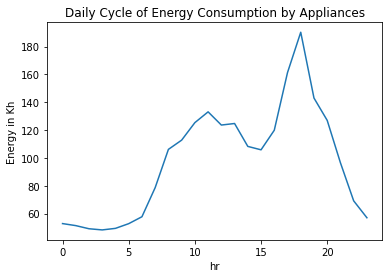

In [35]:
# make the datetime variable the index of the series
data.index = data['date']

# Explore mean energy consumption by appliances
# per hr of the day throughout the 5 months
data.groupby('hr')['Appliances'].mean().plot()
plt.ylabel('Energy in Kh')
plt.title('Daily Cycle of Energy Consumption by Appliances')

During the night, where there is no human activity, there is a baseline energy consumption of about less than 60 Wh. We will use that value later on as the minimum value for the peaks.

Text(0.5, 1.0, 'Mean daily Energy Consumption')

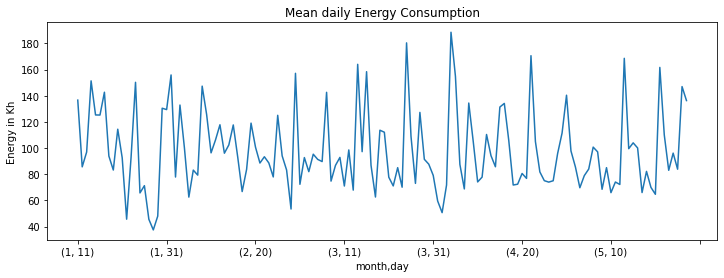

In [36]:
# Plot mean energy consumption by appliances per day throughout the 5 months
data.groupby(['month', 'day'])['Appliances'].mean().plot(figsize=(12, 4))
plt.ylabel('Energy in Kh')
plt.title('Mean daily Energy Consumption')

#### Determining local maxima
- Create a Pandas series with the mean energy consumed by appliances per day throughout the 5 months
- Determine the days of peak electricity consumption throughout the 5 months
    - that is, find the peaks (local maxima)
    - *find_peaks* returns an array with the location of the maxima in the Pandas series
- Plot the peaks
    - plot the time series with the mean energy consumed per day
    - Overlay on top of the time series a series of red dots, at the location of the local maxima, using the peak variable for the x coordinate and the value of the peak for the y coordinate
    - add a line at the baseline electricity consumption of 60 Kh
    - display the plot

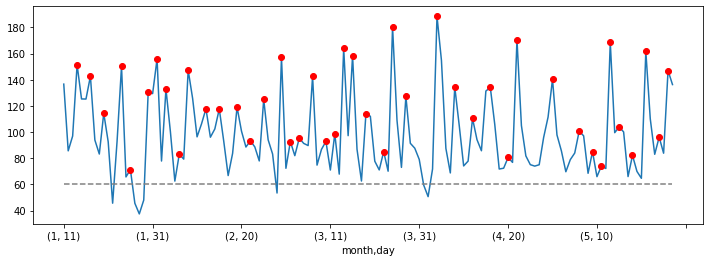

In [37]:
daily_ec = data.groupby(['month', 'day'])['Appliances'].mean()

peaks, _ = find_peaks(daily_ec, height=60)

plt.figure(figsize=(12, 4))
daily_ec.plot()
plt.plot(peaks, daily_ec.values[peaks], "o", color='red')
plt.plot(np.full_like(daily_ec, 60), "--", color="gray")
plt.show()

In [38]:
# peaks contains the indeces of days of max electricity consumption
peaks

array([  3,   6,   9,  13,  15,  19,  21,  23,  26,  28,  32,  35,  39,
        42,  45,  49,  51,  53,  56,  59,  61,  63,  65,  68,  72,  74,
        77,  84,  88,  92,  96, 100, 102, 110, 116, 119, 121, 123, 125,
       128, 131, 134, 136], dtype=int64)

#### Determining local minima
- Determine the days of minimum electricity consumption throughout the 5 months
    - that is, the local minima
    - We use the same function, find_peaks, which means that we need to turn the time series upside-dowm, which we do with the reciprocal function
- Plot the local minima
    - plot the time series with the mean energy consumed per day
    - overlay on top of the time series a series of green dots, at the location of the local minima, using the valleys variable for the x coordinate and the value of the local minima for the y coordinate
    - add a line at the baseline electricity consumption
    - display plot

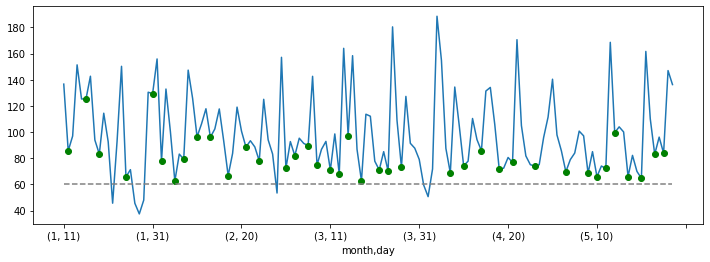

In [39]:
valleys, _ = find_peaks(1 / daily_ec, height=(0, 1/60))

plt.figure(figsize=(12, 4))
daily_ec.plot()
plt.plot(valleys, daily_ec.values[valleys], "o", color='green')
plt.plot(np.full_like(daily_ec, 60), "--", color="gray")
plt.show()

#### Plotting local minima and maxima together

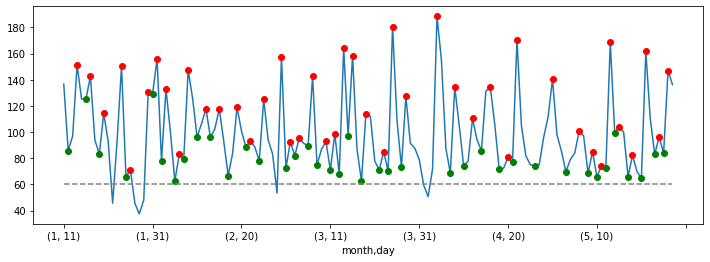

In [40]:
peaks, _ = find_peaks(daily_ec, height=60)
valleys, _ = find_peaks(1 / daily_ec, height=(0, 1/60))

plt.figure(figsize=(12, 4))
daily_ec.plot()
plt.plot(peaks, daily_ec.values[peaks], "o", color='red')
plt.plot(valleys, daily_ec.values[valleys], "o", color='green')
plt.plot(np.full_like(daily_ec, 60), "--", color="gray")
plt.show()

#### There is more...
- In this section, we identified the local maxima and minima in a time series for a single household. 
- But how could we determine the local maxima and minima for several houses?
- We can combine the use of Pandas groupby(), Pandas agg(), and user-defined functions to achieve this goal. 
- To demonstrate how to do this, we will use the mock customer transactions dataset from Featuretools

In [41]:
import featuretools as ft

# load the example data set
data_dict = ft.demo.load_mock_customer()
data = data_dict["transactions"].merge(
    data_dict["sessions"]).merge(data_dict["customers"])
cols = ['customer_id', 'transaction_id', 'transaction_time', 'amount']
data = data[cols]
data.head()

,customer_id,transaction_id,transaction_time,amount
0,2,298,2014-01-01 00:00:00,127.64
1,2,2,2014-01-01 00:01:05,109.48
2,2,308,2014-01-01 00:02:10,95.06
3,2,116,2014-01-01 00:03:15,78.92
4,2,371,2014-01-01 00:04:20,31.54


In [42]:
data['transaction_time'].agg(['min', 'max'])

min   2014-01-01 00:00:00
max   2014-01-01 09:00:35
Name: transaction_time, dtype: datetime64[ns]

In [43]:
data['transaction_time'].dtypes

dtype('<M8[ns]')

In [44]:
# let's create a feature with the hour of the transaction
data['hr'] = data['transaction_time'].dt.hour
data.head()

,customer_id,transaction_id,transaction_time,amount,hr
0,2,298,2014-01-01 00:00:00,127.64,0
1,2,2,2014-01-01 00:01:05,109.48,0
2,2,308,2014-01-01 00:02:10,95.06,0
3,2,116,2014-01-01 00:03:15,78.92,0
4,2,371,2014-01-01 00:04:20,31.54,0


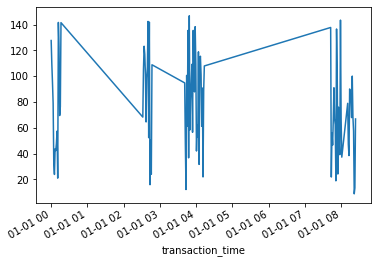

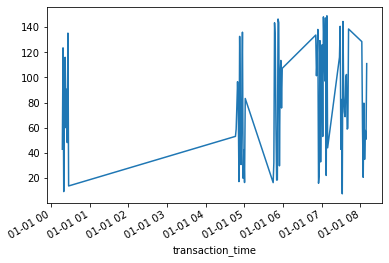

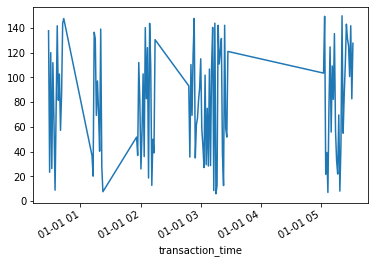

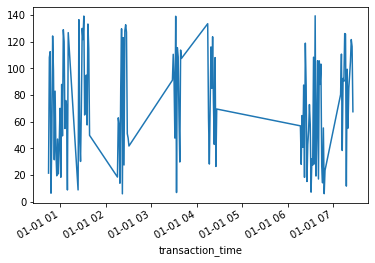

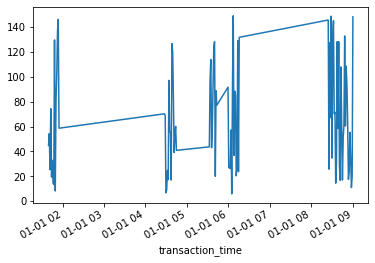

In [45]:
# plot the amount per transaction ==> one plot per customer
for customer in data['customer_id'].unique():

    # make a small df with one customer
    tmp = data[data['customer_id'] == customer]

    # add the transaction time as index
    tmp.index = tmp['transaction_time']

    # plot the amount spent in time
    tmp['amount'].plot()
    plt.show()

- Let's create a function that finds a plots the local maxima of a customer amount spent per transaction time series 
    - x is a Pandas Series
    - find local maxima
    - plot the peaks
- Now let's plot the local maxima for the time series with the mean amount spent per hour ==> one plot per customer
    - this part is intended to get the reader familiar with the data and therefore facilitate the understanding of the code
    - create a small df with a single customer data
    - aggregate the mean amount spent per hr
    - find and plot the local maxima

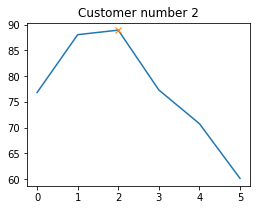

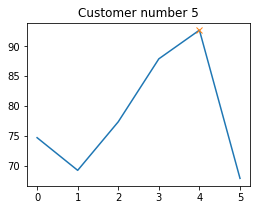

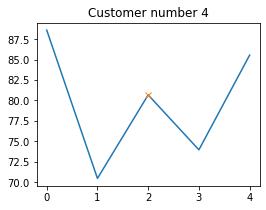

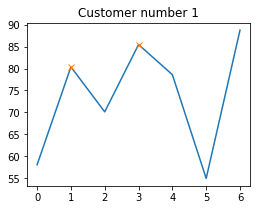

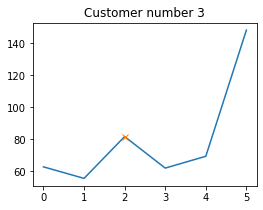

In [46]:
def find_and_plot_peaks(x, customer):
    peaks, _ = find_peaks(x)
    plt.figure(figsize=(4, 3))
    plt.plot(x.values)
    plt.plot(peaks, x.values[peaks], "x")
    plt.title('Customer number {}'.format(customer))
    plt.show()
    
for customer in data['customer_id'].unique():
    tmp = data[data['customer_id']==customer]
    tmp = tmp.groupby('hr')['amount'].mean()
    pd.DataFrame(tmp).reset_index(inplace=True, drop=False)
    find_and_plot_peaks(tmp, customer)

In [47]:
# create functions that take a time series and return number of local maxima or local minima
def find_no_peaks(x):
    peaks, _ = find_peaks(x)
    return len(peaks)

def find_no_valleys(x):
    valleys, _ = find_peaks(1/x)
    return len(valleys)

# select a single customer data to test function
tmp = data[data['customer_id'] == 3]
tmp = tmp.groupby('hr')['amount'].mean()
tmp

hr
1     62.791333
4     55.579412
5     81.747500
6     62.019333
8     69.403939
9    148.310000
Name: amount, dtype: float64

In [48]:
# test local maxima function
find_no_peaks(tmp)

1

In [49]:
# test local minima function
find_no_valleys(tmp)

2

In [50]:
# find number of local maxima in all customers
data.groupby(['customer_id', 'hr'])['amount'].mean().groupby(
    'customer_id').apply(find_no_peaks)

customer_id
1    2
2    1
3    1
4    1
5    1
Name: amount, dtype: int64

In [51]:
# find both local maxima and minima in all customers
data.groupby(['customer_id', 'hr'])['amount'].mean().groupby(
    'customer_id').agg([find_no_peaks, find_no_valleys])

,find_no_peaks,find_no_valleys
customer_id,,
1,2.0,2.0
2,1.0,0.0
3,1.0,2.0
4,1.0,2.0
5,1.0,1.0


## 10.4 Deriving time elapsed between time-stamped events

- In the previous sections, we performed mathematical operations over the values of the time series to obtain new features that summarize information about the variable, such as the mean and maximum values or the cumulative sum. 
- It is also possible to perform these mathematical operations over the time-stamp and obtain information about the time between transactions or the time between specific events.
- In this section, we will calculate the time between transactions, that is, the time between successive records of the variable values. 
- Then, we will determine the time between specific events, such as the time between peaks of energy consumption, to demonstrate the power of Pandas when it comes to aggregating time series data.

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [53]:
data = pd.read_csv('data/energydata.csv')
data.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [54]:
# parse as datetime data type
data['date'] = pd.to_datetime(data['date'])

# determine time between transactions (energy records)
data['time_since_previous'] = data['date'].diff()
data['time_since_previous'] = data['time_since_previous']/np.timedelta64(1,'m')

data[['date', 'time_since_previous']].head()

,date,time_since_previous
0,2016-01-11 17:00:00,NaN
1,2016-01-11 17:10:00,10.0
2,2016-01-11 17:20:00,10.0
3,2016-01-11 17:30:00,10.0
4,2016-01-11 17:40:00,10.0


In [55]:
# extract day and month from datetime variable
data[['day', 'month']] = pd.DataFrame([(x.day, x.month) for x in data['date']])

data.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,time_since_previous,day,month
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,NaN,11,1
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,10.0,11,1
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,10.0,11,1
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389,10.0,11,1
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,10.0,11,1


In [56]:
# make the datetime variable the index of the series
data.index = data['date']

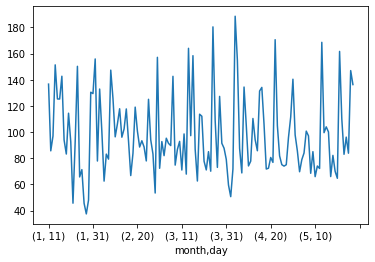

In [57]:
# Plot mean energy consumption by appliances per day
data.groupby(['month', 'day'])['Appliances'].mean().plot()

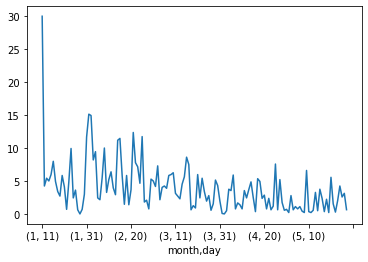

In [58]:
# Plot mean energy consumption by lights per day
data.groupby(['month', 'day'])['lights'].mean().plot()

In [59]:
# create pandas series with the mean energy consumption per day

# electricity consumption by appliances per day
elec_pday = data.groupby(['month', 'day'])['Appliances'].mean()

# light energy consumption per day
light_pday = data.groupby(['month', 'day'])['lights'].mean()

# find the peaks, that is, the local maxima
peaks, _ = find_peaks(elec_pday.values, height=60)

peaks

array([  3,   6,   9,  13,  15,  19,  21,  23,  26,  28,  32,  35,  39,
        42,  45,  49,  51,  53,  56,  59,  61,  63,  65,  68,  72,  74,
        77,  84,  88,  92,  96, 100, 102, 110, 116, 119, 121, 123, 125,
       128, 131, 134, 136], dtype=int64)

In [60]:
# compare the shape of the time series with that of the selected local maxima series
elec_pday.shape, elec_pday[peaks].shape

((138,), (43,))

In [61]:
# select only the values of the series with the local maxima
elec_pday[peaks][:20]

month  day
1      14     151.388889
       17     142.708333
       20     114.444444
       24     150.277778
       26      71.319444
       30     130.486111
2      1      155.902778
       3      132.916667
       6       83.194444
       8      147.361111
       12     117.847222
       15     117.708333
       19     119.097222
       22      93.402778
       25     125.069444
       29     157.152778
3      2       92.777778
       4       95.347222
       7      142.638889
       10      92.916667
Name: Appliances, dtype: float64

In [62]:
# capture the series with local maxima in a pandas dataframe
# then reset index so that the month and day become part of the columns

# finally, we need to add the year, to be able to reconstitute the date
# from the existing time columns
tmp = pd.DataFrame(elec_pday[peaks]).reset_index(drop=False)
tmp['year'] = 2016
tmp.head()

,month,day,Appliances,year
0,1,14,151.388889,2016
1,1,17,142.708333,2016
2,1,20,114.444444,2016
3,1,24,150.277778,2016
4,1,26,71.319444,2016


In [63]:
# reconstitute the datetime variable
tmp['date'] = pd.to_datetime(tmp[['year', 'month', 'day']])

tmp.head()

,month,day,Appliances,year,date
0,1,14,151.388889,2016,2016-01-14
1,1,17,142.708333,2016,2016-01-17
2,1,20,114.444444,2016,2016-01-20
3,1,24,150.277778,2016,2016-01-24
4,1,26,71.319444,2016,2016-01-26


In [64]:
# calculate the distance, in days, between the local maxima
# we do this utilizing the dataframe with only the local maxima
tmp['peak_distance'] = tmp['date'].diff()
tmp['peak_distance'] = tmp['peak_distance'].dt.days

tmp.head()

,month,day,Appliances,year,date,peak_distance
0,1,14,151.388889,2016,2016-01-14,NaN
1,1,17,142.708333,2016,2016-01-17,3.0
2,1,20,114.444444,2016,2016-01-20,3.0
3,1,24,150.277778,2016,2016-01-24,4.0
4,1,26,71.319444,2016,2016-01-26,2.0


#### Putting all the steps together in a function:
It's useful know how to automate the calculation of peak distances across variables:
- find local maxima
- select the series values with local maxima only
- transform the series into a dataframe with the month and day index as columns
- add year to reconstitute date
- reconstitute date
- calculate difference in days between local maxima
- return difference in days between local maxima that is a Pandas Series
Apply the function:
- return a series with a difference in days respect to the previous local maxima for the time series with the mean daily energy consumption by lights
- display first 10 values of the series distances[0:10]

In [65]:
def time_between_peaks(ser):   
    peaks, _ = find_peaks(ser.values)    
    tmp = pd.DataFrame(ser[peaks]).reset_index(drop=False)    
    tmp['year'] = 2016 
    tmp['date'] = pd.to_datetime(tmp[['year', 'month', 'day']])
    tmp['peak_distance'] = tmp['date'].diff()
    tmp['peak_distance'] = tmp['peak_distance'].dt.days 
    return tmp['peak_distance']

distances = time_between_peaks(light_pday)
distances[:10]

0    NaN
1    3.0
2    4.0
3    4.0
4    2.0
5    6.0
6    3.0
7    4.0
8    3.0
9    4.0
Name: peak_distance, dtype: float64

#### To determine distance between local maxima and minima
We need to calculate both, and then concatenate the arrays, and use that to select the data
- determine the days of minimum electricity consumption throughout the 5 months, that is the local minima
    - we use peak values but we turn the series upside down with the reciprocal function
- compare the number of observations in the entire series vs the number of local maxima, vs the number of local minima
- concatenate the indices that contain the local minima and maxima and then sort its values

In [66]:
valleys, _ = find_peaks(1 / elec_pday.values, height=(-np.Inf, 1/60))
valleys

array([  1,   5,   8,  14,  20,  22,  25,  27,  30,  33,  37,  41,  44,
        50,  52,  55,  57,  60,  62,  64,  67,  71,  73,  76,  87,  90,
        94,  98, 101, 106, 113, 118, 120, 122, 124, 127, 130, 133, 135],
      dtype=int64)

In [67]:
elec_pday.shape, elec_pday[peaks].shape, elec_pday[valleys].shape

((138,), (43,), (39,))

In [68]:
peaksandvalleys = np.concatenate([peaks, valleys])
peaksandvalleys.sort()
peaksandvalleys

array([  1,   3,   5,   6,   8,   9,  13,  14,  15,  19,  20,  21,  22,
        23,  25,  26,  27,  28,  30,  32,  33,  35,  37,  39,  41,  42,
        44,  45,  49,  50,  51,  52,  53,  55,  56,  57,  59,  60,  61,
        62,  63,  64,  65,  67,  68,  71,  72,  73,  74,  76,  77,  84,
        87,  88,  90,  92,  94,  96,  98, 100, 101, 102, 106, 110, 113,
       116, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 130, 131,
       133, 134, 135, 136], dtype=int64)

In [69]:
# now we use this index to select the data
elec_pday[peaksandvalleys].shape

(82,)

- To determine the time elapsed between local maxima and minima, we need create a dataframe with those values executing:
        tmp = pd.DataFrame(elec_pday[peaksandvalleys]).reset_index(drop=False)
- and then,     
        1) add the year, 
        2) reconstitute the date, and 
        3) calculate the time between the local maxima and minima, as we have done in previous cells.
        
#### There is more...
- We can determine the mean difference between events for various customers or entities.
- Let's work with the mock customer transactions data set as example.

In [70]:
import featuretools as ft

# load data set from feature tools
data_dict = ft.demo.load_mock_customer()

data = data_dict["transactions"].merge(
    data_dict["sessions"]).merge(data_dict["customers"])
cols = ['customer_id', 'transaction_id', 'transaction_time', 'amount']
data = data[cols]

data.head()

,customer_id,transaction_id,transaction_time,amount
0,2,298,2014-01-01 00:00:00,127.64
1,2,2,2014-01-01 00:01:05,109.48
2,2,308,2014-01-01 00:02:10,95.06
3,2,116,2014-01-01 00:03:15,78.92
4,2,371,2014-01-01 00:04:20,31.54


In [71]:
# Let's first calculate the time since previous transaction 
data.sort_values(by=['transaction_time'], ascending=True, inplace=True)

# calculate time since previous transaction in hours
data['time_since_previous'] = data['transaction_time'].diff()
data['time_since_previous'] = data['time_since_previous']/np.timedelta64(1,'h')

# calculate mean time between transactions per customer
# all transactions occur every 1h and 5 min in the toy data set
# so the result is a bit boring, but you get the yiest
tmp = data.groupby('customer_id')['time_since_previous'].mean()
tmp

customer_id
1    0.018056
2    0.018056
3    0.018056
4    0.018056
5    0.018056
Name: time_since_previous, dtype: float64

In [72]:
# Now, let's calculate the time between local extrema
# extract the hour of the transaction
data['hr'] = data['transaction_time'].dt.hour

data.head()

,customer_id,transaction_id,transaction_time,amount,time_since_previous,hr
0,2,298,2014-01-01 00:00:00,127.64,NaN,0
1,2,2,2014-01-01 00:01:05,109.48,0.018056,0
2,2,308,2014-01-01 00:02:10,95.06,0.018056,0
3,2,116,2014-01-01 00:03:15,78.92,0.018056,0
4,2,371,2014-01-01 00:04:20,31.54,0.018056,0


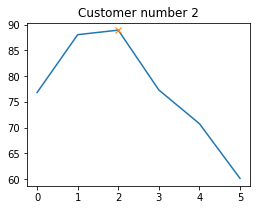

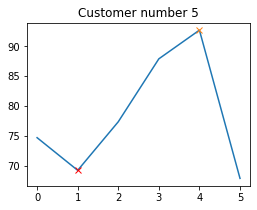

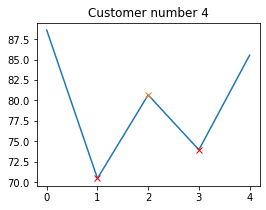

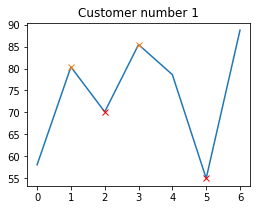

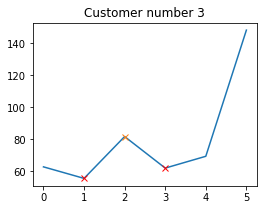

In [73]:
# now let's plot the local maxima for the time series with 
# the mean amount spent per hour ==> one plot per customer
def find_and_plot_peaks(x, customer):

    # find local maxima and minima
    peaks, _ = find_peaks(x)
    valleys, _ = find_peaks(1/x)
    
    # plot the peaks and valleys
    plt.figure(figsize=(4,3))
    plt.plot(x)
    plt.plot(peaks, x[peaks], "x")
    plt.plot(valleys, x[valleys], "x", color='red')
    plt.title('Customer number {}'.format(customer))
    plt.show()
    
# make a plot per customer, with local minima and maxima of amount spent per hr
for customer in data['customer_id'].unique():
    tmp = data[data['customer_id']==customer]
    tmp = tmp.groupby('hr')['amount'].mean()
    tmp.reset_index(drop=True, inplace=True)
    find_and_plot_peaks(tmp, customer)

Let's create a series of functions to find the local maxima and minima put the arrays together, and then slice the original series into those values, to finally calculate the time elapsed between them
- These functions operate at a pandas series level (x is a pandas series)
    - finds number of local maxima
    - finds number of local minima
    - concatenates the indices of the peaks and valleys     
    - selects the points with peaks and valleys in the series and determines the hr difference between them.
        -finally, returns the mean distance between all local maxima and minima

In [74]:
def find_no_peaks(x):
    peaks, _ = find_peaks(x)
    return peaks

def find_no_valleys(x): 
    valleys, _ = find_peaks(1/x)
    return valleys

def concatenate_pav(x):    
    ids = np.concatenate([find_no_peaks(x), find_no_valleys(x)])
    ids.sort()
    return ids

def slice_and_measure(x):
    ids = concatenate_pav(x)
    tmp = pd.DataFrame(x.iloc[ids]).reset_index(drop=False)
    t = tmp['hr'].diff()
    return t.mean(skipna=True)

In [75]:
# let's test the functions using the data of customer 3 
df = data[data['customer_id'] == 3]
df = df.groupby('hr')['amount'].mean()
df

hr
1     62.791333
4     55.579412
5     81.747500
6     62.019333
8     69.403939
9    148.310000
Name: amount, dtype: float64

In [76]:
# test function that finds number of peaks
peaks = find_no_peaks(df)
peaks

array([2], dtype=int64)

In [77]:
# test function that finds number of valleys
valleys = find_no_valleys(df)
valleys

array([1, 3], dtype=int64)

In [78]:
# test concatenate function
ids = concatenate_pav(df)
ids

array([1, 2, 3], dtype=int64)

In [79]:
# test result of concatenate_pav when applied to the
# entire dataset: that would be the indeces with max and min
# transaction amount per customer
data.groupby(['customer_id', 'hr'])['amount'].mean().groupby('customer_id').apply(concatenate_pav)

customer_id
1    [1, 2, 3, 5]
2             [2]
3       [1, 2, 3]
4       [1, 2, 3]
5          [1, 4]
Name: amount, dtype: object

In [80]:
# step by step the inner code of the function slide_and_measure()
tmp = pd.DataFrame(df.iloc[ids]).reset_index(drop=False)
t = tmp['hr'].diff()
t

0    NaN
1    1.0
2    1.0
Name: hr, dtype: float64

In [81]:
# output of slide_and_measure()
t.mean(skipna=True)

1.0

In [82]:
# test slide_and_measure() on 1 customer
slice_and_measure(df)

1.0

In [83]:
# apply slide_and_measure() to the entire data set
data.groupby(['customer_id', 'hr'])['amount'].mean().groupby(
    'customer_id').apply(slice_and_measure)

customer_id
1    1.666667
2         NaN
3    1.000000
4    1.000000
5    3.000000
Name: amount, dtype: float64

## 10.5 Creating features from transactions with Featuretools

- Featuretools is an open source Python library that allows us to automatically create features from time series and transactional databases with multiple transaction records for each specific entity, such as customers. 
- With Featuretools, we can automatically create features at the transaction level. 
- Such features include the day, month, and year from a datetimevariable, the time between transactions, or if the transaction occurred on a weekend, as well as the cumulative sum or the difference in value between transactions.
- Featuretools also aggregates existing and new features at the entity level—in our example, at the customer level—using mathematical and statistical operations, such as the ones we used in the "*Aggregating transactions with mathematical operations*" recipe of this chapter or by using user-defined operations.
- In this recipe, we will create features at the transaction level and then aggregate both new and existing features at the customer level by using Featuretool's automatic feature extraction functionality.

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import featuretools as ft

In [85]:
# let's load the example data set from feature tools
data_dict = ft.demo.load_mock_customer()

data = data_dict["transactions"].merge(
    data_dict["sessions"]).merge(data_dict["customers"])

cols = ['customer_id',
        'transaction_id',
        'transaction_time',
        'amount',
        ]
data = data[cols]
data.head()

,customer_id,transaction_id,transaction_time,amount
0,2,298,2014-01-01 00:00:00,127.64
1,2,2,2014-01-01 00:01:05,109.48
2,2,308,2014-01-01 00:02:10,95.06
3,2,116,2014-01-01 00:03:15,78.92
4,2,371,2014-01-01 00:04:20,31.54


In [86]:
print('Number of customers: {}'.format(data['customer_id'].nunique()))
print('Number of transactions: {}'.format(data['transaction_id'].nunique()))

Number of customers: 5
Number of transactions: 500


In [87]:
data.dtypes

customer_id                  int64
transaction_id               int64
transaction_time    datetime64[ns]
amount                     float64
dtype: object

In [88]:
# in order for Featuretools to work, we need to create entity sets
es = ft.EntitySet(id="customer_data")

# entity set with the transactions
es.entity_from_dataframe(entity_id='transactions',
                         dataframe=data,
                         index="transaction_id",
                         time_index='transaction_time')
es

Entityset: customer_data
  Entities:
    transactions [Rows: 500, Columns: 4]
  Relationships:
    No relationships

In [89]:
# within the entity set there is another table
es.normalize_entity(base_entity_id="transactions",
                    new_entity_id="customers",
                    index="customer_id")

Entityset: customer_data
  Entities:
    transactions [Rows: 500, Columns: 4]
    customers [Rows: 5, Columns: 2]
  Relationships:
    transactions.customer_id -> customers.customer_id

### Creating new features from the existing data - without aggregations
Featuretools automatically creates more fearures from those present in the data set for every single transaction, that is without aggregation:
1. Create a feature from the datetime variable signalling # if the transaction occurred on a weekend
2. Determines the cumulative transaction amount,
3. Determine the cumulative number of transactions,
4. Creates a new feature indicating the time since the previous transaction

All of these operations occur at a transaction level, that is, transaction after transaction
- set up the dfs from featuretools to return the previous features
- it is important to leave agg_primitives as an empty list, so that featuretools does not
- aggregate the data at a customer level as well

In [90]:
transf_operations = ['is_weekend', 'cum_sum', 'cum_count','time_since_previous']

feature_matrix, features = ft.dfs(entityset=es,
                      target_entity="transactions",
                      agg_primitives=[],
                      trans_primitives=transf_operations,
                      verbose=True)
feature_matrix.head()

Built 8 features
Elapsed: 00:00 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


,customer_id,amount,IS_WEEKEND(transaction_time),CUM_SUM(amount),CUM_COUNT(customer_id),TIME_SINCE_PREVIOUS(transaction_time),customers.IS_WEEKEND(first_transactions_time),customers.TIME_SINCE_PREVIOUS(first_transactions_time)
transaction_id,,,,,,,,
298,2,127.64,False,127.64,1,NaN,False,NaN
2,2,109.48,False,237.12,2,65.0,False,NaN
308,2,95.06,False,332.18,3,65.0,False,NaN
116,2,78.92,False,411.10,4,65.0,False,NaN
371,2,31.54,False,442.64,5,65.0,False,NaN


In [91]:
# original dataframe and derived feature_matrix should have same number of observations
data.shape, feature_matrix.shape

((500, 4), (500, 8))

- If we don't indicate the operations to perform to create new features, Featuretools will perform the default operations, which can be found [here](https://docs.featuretools.com/en/stable/generated/featuretools.dfs.html)
- If we had more than 1 numeric feature in our dataframe, we could create new feautres by addition or multiplication as we did in recipe Combining multiple features with statistical operations of Chapter 9, *Applying Mathematical Computations to Features*
    - for code on how to do that check this [link](https://stackoverflow.com/questions/55155371/how-to-use-featuretools-to-create-features-for-a-single-table-with-no-immediate/55172142#55172142)

In [92]:
# details in the types of features that we can create
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 500
primitives[primitives['type'] == 'transform'][:10]

,name,type,dask_compatible,description
22,less_than_scalar,transform,True,Determines if values are less than a given scalar.
23,diff,transform,False,Compute the difference between the value in a list and the
24,absolute,transform,True,Computes the absolute value of a number.
25,cum_max,transform,False,Calculates the cumulative maximum.
26,equal_scalar,transform,True,Determines if values in a list are equal to a given scalar.
27,num_words,transform,True,Determines the number of words in a string by counting the spaces.
28,cum_min,transform,False,Calculates the cumulative minimum.
29,add_numeric_scalar,transform,True,Add a scalar to each value in the list.
30,greater_than_equal_to_scalar,transform,True,Determines if values are greater than or equal to a given scalar.
31,month,transform,True,Determines the month value of a datetime.


### Creating new features from the existing data - with aggregations
- These are the features we can create when we want a flattened view of our dataframe, that is one row per customer
- Differently from the previous case, here we want to aggregate the information at customer level, so we want a summary view of each customer
    - first we aggregate only the existing variables that is the transaction amount; we want the mean and maximum transaction amount per customer
    - next we will create a new feature as done earlier, and more specifically, we will create the feature time_since_previous transaction and aggregate the new feature together with the pre-existing variable transaction amount, all in one go
    - note how the final dataframe contains as many rows as different customers in the data set
    - and next we create 2 new features and aggregate both together with the transaction amount

In [93]:
feature_matrix, features = ft.dfs(entityset=es,
                      target_entity="customers",
                      agg_primitives=["mean", 'max'],
                      trans_primitives=[],
                      verbose=True)
feature_matrix

Built 2 features
Elapsed: 00:00 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


,MEAN(transactions.amount),MAX(transactions.amount)
customer_id,,
2,77.422366,146.81
5,80.375443,149.02
4,80.070459,149.95
1,71.631905,139.43
3,67.060430,149.15


In [94]:
feature_matrix, features = ft.dfs(entityset=es,
                      target_entity="customers",
                      agg_primitives=["mean", 'max'],
                      trans_primitives=['time_since_previous'],
                      verbose=True)
feature_matrix

Built 5 features
Elapsed: 00:00 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


,MEAN(transactions.amount),MAX(transactions.amount),TIME_SINCE_PREVIOUS(first_transactions_time),MEAN(transactions.TIME_SINCE_PREVIOUS(transaction_time)),MAX(transactions.TIME_SINCE_PREVIOUS(transaction_time))
customer_id,,,,,
2,77.422366,146.81,NaN,65.0,65.0
5,80.375443,149.02,1040.0,65.0,65.0
4,80.070459,149.95,650.0,65.0,65.0
1,71.631905,139.43,975.0,65.0,65.0
3,67.060430,149.15,3315.0,65.0,65.0


In [95]:
data.shape, feature_matrix.shape

((500, 4), (5, 5))

In [96]:
feature_matrix, features = ft.dfs(entityset=es,
                      target_entity="customers",
                      agg_primitives=["mean", 'max'],
                      trans_primitives=['cum_sum','time_since_previous'],
                      verbose=True)
feature_matrix

Built 9 features
Elapsed: 00:00 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


,MEAN(transactions.amount),MAX(transactions.amount),TIME_SINCE_PREVIOUS(first_transactions_time),MEAN(transactions.CUM_SUM(amount)),MEAN(transactions.TIME_SINCE_PREVIOUS(transaction_time)),MAX(transactions.CUM_SUM(amount)),MAX(transactions.TIME_SINCE_PREVIOUS(transaction_time)),CUM_SUM(MAX(transactions.amount)),CUM_SUM(MEAN(transactions.amount))
customer_id,,,,,,,,,
2,77.422366,146.81,NaN,18794.182366,65.0,35101.22,65.0,146.81,77.422366
5,80.375443,149.02,1040.0,24258.206582,65.0,34296.39,65.0,295.83,157.797809
4,80.070459,149.95,650.0,12455.024495,65.0,23418.09,65.0,445.78,237.868267
1,71.631905,139.43,975.0,16566.784048,65.0,31291.89,65.0,585.21,309.500172
3,67.060430,149.15,3315.0,25387.640538,65.0,37539.86,65.0,734.36,376.560602


In [97]:
data.shape, feature_matrix.shape

((500, 4), (5, 9))

### Integrating user defined functions
In the remaining lines, instead of using Featuretools pre-coded functions, we will create our own.

In [98]:
from featuretools.primitives import make_trans_primitive, make_agg_primitive
from featuretools.variable_types import Numeric
from scipy.signal import find_peaks

def find_no_peaks(column):
    peaks, _ = find_peaks(column)
    return len(peaks)

def find_no_valleys(column):
    valleys, _ = find_peaks(1 / column)
    return len(valleys)

FindNoPeaks = make_agg_primitive(function=find_no_peaks,
                                 input_types=[Numeric],
                                 return_type=Numeric)

FindNoValleys = make_agg_primitive(function=find_no_valleys,
                                   input_types=[Numeric],
                                   return_type=Numeric)

# and now let's use our 2 new aggregation functions with mean and max
feature_matrix, features = ft.dfs(entityset=es,
                      target_entity="customers",
                      agg_primitives=[FindNoPeaks, FindNoValleys, 'mean', 'max'],
                      trans_primitives=[],
                      verbose=True)
feature_matrix

Built 4 features
Elapsed: 00:00 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


,FIND_NO_PEAKS(transactions.amount),FIND_NO_VALLEYS(transactions.amount),MEAN(transactions.amount),MAX(transactions.amount)
customer_id,,,,
2,28.0,29.0,77.422366,146.81
5,26.0,26.0,80.375443,149.02
4,37.0,38.0,80.070459,149.95
1,43.0,42.0,71.631905,139.43
3,29.0,29.0,67.060430,149.15
